In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import os
import warnings
warnings.filterwarnings('ignore')


### Preprocessing

In [2]:
df = pd.read_csv('../build_dataset/output_csv/bloomberg_data.csv')
df = df.dropna(subset=['Offer To 1st Close'])
df.head(3)

,Issuer Ticker,Issuer Name,Sales - 1 Yr Growth,Profit Margin,Return on Assets,Offer Size (M),Shares Outstanding (M),Offer Price,Offer To 1st Close,Market Cap at Offer (M),...,Instit Owner (Shares Held),Filing Term Price Range,Priced Range,Industry Sector,Industry Group,Industry Subgroup,Fed Rate,CPI,Consumer Confidence,Unemployment Rate
0,0000492D US,Pioneer Municipal and Equity I,NaN,NaN,NaN,430.50,0.0000,15.0,0.000000,0.00,...,NaN,NaN,NaN,Financial,Country Funds-Closed-end,Finance-Investment Fund,0.94,0.488334,103.8,5.7
1,0000708D US,Spirit Finance Corp/Old,128.2,27.7,2.1,330.00,63.5068,11.0,12.727273,698.57,...,NaN,10.50 - 12.50,Priced Within Range,Financial,REITS,REITS-Diversified,2.04,-0.366492,97.1,5.4
2,0117799D US,Penn Virginia GP Holdings LP,31.5,4.3,2.9,127.65,39.0250,18.5,-2.702703,721.96,...,NaN,18 - 20,Priced Within Range,Energy,Coal,Coal,5.27,0.148883,91.7,4.4


In [3]:
def convert_trade_date(df):
    """
    Convert the 'Trade Date (US)' column to separate columns for 
    month, day, and year, and drop the original 'Trade Date (US)' column.
    """
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    return df

df_convert_trade_date = convert_trade_date(df)

In [4]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_trade_date)

In [5]:
def encoding(df):
    """
    Split the DataFrame into development and testing sets.

    Fill missing values with the mode for categorical
    columns and the mean for numerical columns.

    Encode columns in the DataFrame:

      - Categorical columns are encoded using OneHotEncoder.
      - Numerical columns are scaled using StandardScaler.
      - Ordinal columns are encoded using OrdinalEncoder.

    Create df_dev and df_test using the transformed features.
    """

    X = df.drop(columns=['Offer To 1st Close'])
    y = df['Offer To 1st Close']

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for col in X_dev.columns:
        if X_dev[col].dtype == 'object':
            X_dev[col] = X_dev[col].fillna(X_dev[col].mode()[0])
            X_test[col] = X_test[col].fillna(X_dev[col].mode()[0])
        else:
            X_dev[col] = X_dev[col].fillna(X_dev[col].mean())
            X_test[col] = X_test[col].fillna(X_test[col].mean())

    # Validate no missing values
    assert not X_dev.isnull().any().any(), "Missing values found in development set"
    assert not X_test.isnull().any().any(), "Missing values found in test set"

    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year']
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_columns]

    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    df_dev['Offer To 1st Close'] = y_dev.reset_index(drop=True)
    df_test['Offer To 1st Close'] = y_test.reset_index(drop=True)

    assert not df_dev.isna().any().any(), "Missing values found in development set"
    assert not df_test.isna().any().any(), "Missing values found in test set"
    assert len(df_dev.columns) == len(df_test.columns), "Mismatch in number of features"
    assert 'Offer To 1st Close' in df_dev.columns and 'Offer To 1st Close' in df_test.columns, "Target column missing"

    return df_dev, df_test


df_dev_encoding, df_test_encoding = encoding(df_drop_columns)

In [7]:
def show_feature_importance(df_dev):
    """
    Calculate feature importance using a simple model
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_dev, y_dev)
    importances = pd.Series(rf.feature_importances_, index=X_dev.columns)
    print("\nFeature Importances:")
    print(importances.sort_values(ascending=False).head(10))

show_feature_importance(df_dev_encoding)



Feature Importances:
ss__Offer Price                    0.206860
ss__Consumer Confidence            0.153280
ss__Market Cap at Offer (M)        0.079405
ss__Return on Assets               0.064225
ss__Sales - 1 Yr Growth            0.036884
oe__Trade Day                      0.035344
ss__Fed Rate                       0.031307
ss__Instit Owner (% Shares Out)    0.029265
ss__Profit Margin                  0.027888
ss__Cash Flow per Share            0.027364
dtype: float64


In [8]:
def get_correlation(df_dev, df_test):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']

    X_test = df_test.drop(columns=['Offer To 1st Close'])
    y_test = df_test['Offer To 1st Close']

    corr_matrix = X_dev.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced = X_dev.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_dev = pd.concat([X_reduced, y_dev.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")

    df_test.to_csv('./output_csv/Final_Output_Reg_test.csv', index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = get_correlation(df_dev_encoding, df_test_encoding)

Removed 32 correlated features.


In [9]:
def remove_outlier(df):
    """
    Remove outliers using both IQR on target variable and standardized residuals
    """
    # First pass: Remove outliers based on target variable
    label = df['Offer To 1st Close']
    Q1 = label.quantile(0.25)
    Q3 = label.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_filtered = df[(label >= lower_bound) & (label <= upper_bound)]
    
    # Second pass: Remove outliers based on standardized residuals
    X = df_filtered.drop(columns=['Offer To 1st Close'])
    y = df_filtered['Offer To 1st Close']
    
    # Fit a simple linear model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Calculate standardized residuals
    residuals = y - y_pred
    std_residuals = (residuals - residuals.mean()) / residuals.std()
    
    # Remove samples with standardized residuals beyond ±3
    df_filtered = df_filtered[abs(std_residuals) <= 3]
    
    print(f"Removed outliers.")
    print(f"Original count: {len(df)}")
    print(f"After IQR filtering: {len(df_filtered)}")
    print(f"After residual filtering: {len(df_filtered)}")
    
    return df_filtered, (lower_bound, upper_bound)

In [10]:
def checkoutliers(df, outfile):
    """
    Print distribution of the target variable and check for outliers.
    """
    label = df['Offer To 1st Close']

    print('Distribution statistics:')
    print('Minimum value: ', label.min())
    print('Q1: ', label.quantile(0.25))
    print('Median value: ', label.median())
    print('Q3: ', label.quantile(0.75))
    print('Maximum value: ', label.max())
    print('Mean value: ', label.mean())
    print('Standard deviation: ', label.std())
    print('\nChecking for outliers...')
    
    df_filtered, bounds = remove_outlier(df)
    df_filtered.to_csv(outfile, index=False)
    return df_filtered, bounds

df_dev_filtered, bounds = checkoutliers(df_dev_correlation, './output_csv/Final_Output_Reg_dev.csv')

Distribution statistics:
Minimum value:  -100.0
Q1:  0.0
Median value:  2.225000024
Q3:  18.6511621475
Maximum value:  507.5
Mean value:  14.727079712040686
Standard deviation:  34.38288981181933

Checking for outliers...
Removed outliers.
Original count: 3146
After IQR filtering: 2788
After residual filtering: 2788


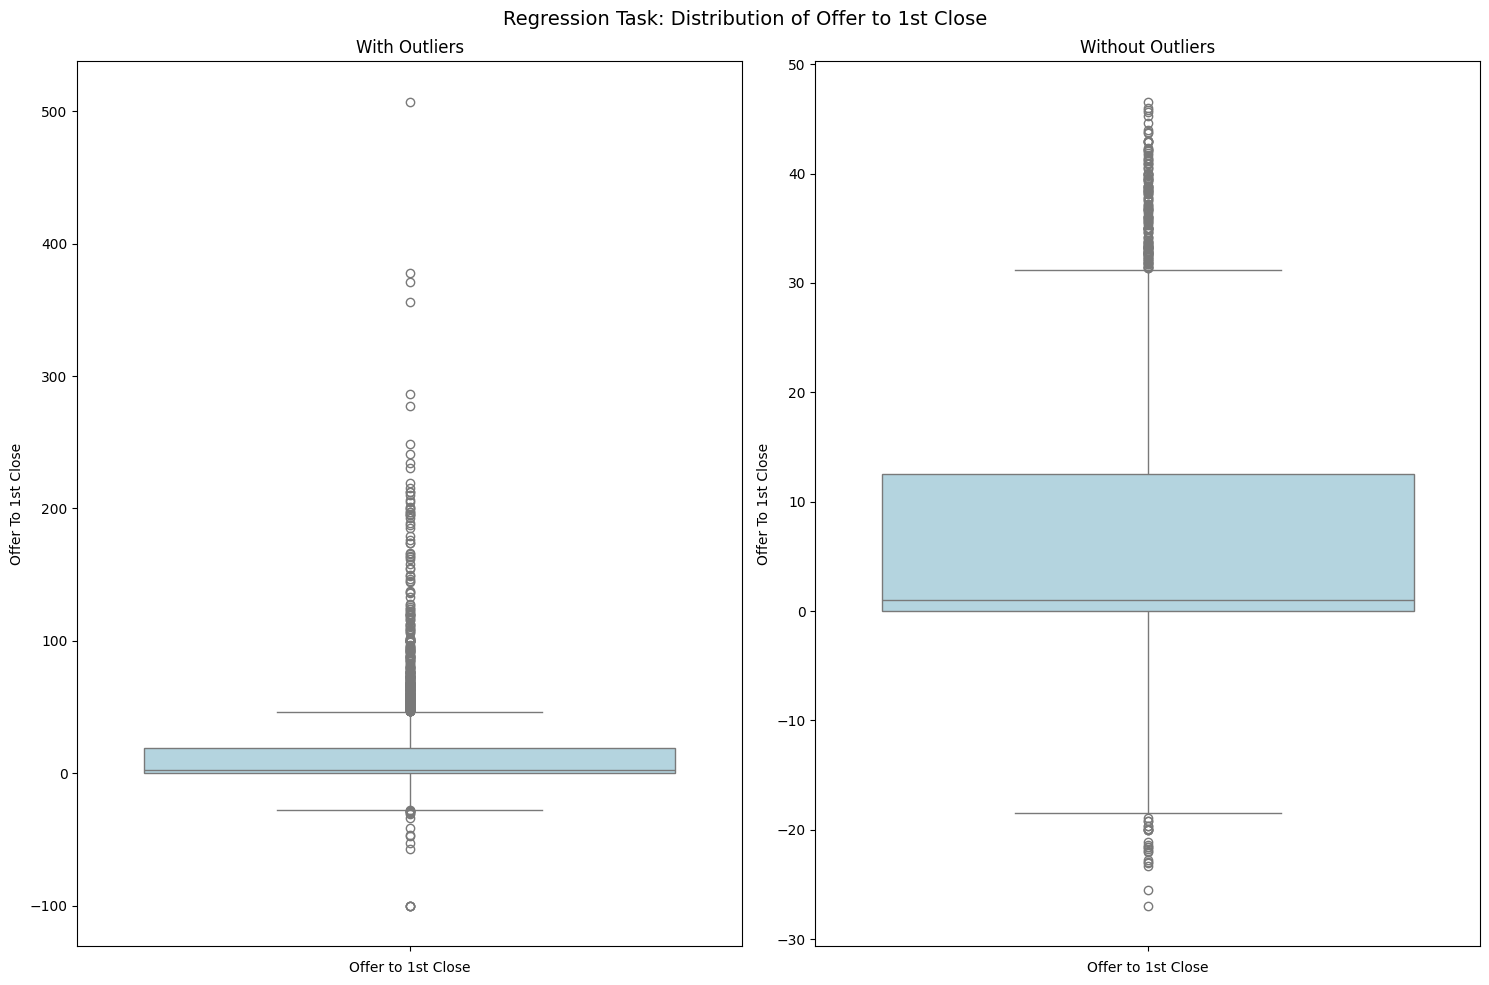

In [11]:
def display_distribution(df_dev_filtered, df_dev_correlation):
    """
    Display distribution of target variable before and after removing outliers.
    """
    df_no_outliers = df_dev_filtered.copy()
    df_with_outliers = df_dev_correlation.copy()

    fig, axs = plt.subplots(ncols=2, figsize=(15, 10))

    sns.boxplot(data=df_with_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[0])
    axs[0].set_title('With Outliers')
    axs[0].set_xlabel('Offer to 1st Close')

    sns.boxplot(data=df_no_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[1])
    axs[1].set_title('Without Outliers')
    axs[1].set_xlabel('Offer to 1st Close')

    fig.suptitle('Regression Task: Distribution of Offer to 1st Close', fontsize=14)
    plt.tight_layout()
    plt.show()

display_distribution(df_dev_filtered, df_dev_correlation)

### Model Training

In [12]:
def split_data(df, target_col='Offer To 1st Close'):
    """
    Preprocess the data with feature engineering and scaling
    """
    X = df.drop(columns=target_col)
    y = df[target_col]
    return X, y

In [13]:
def get_enhanced_model_params():
    """Return enhanced model parameters with wider search space"""
    return {
        "Linear Regression": {
            "model": LinearRegression(n_jobs=-1),
            "params": {}
        },
        "Ridge Regression": {
            "model": Ridge(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }
        },
        "Lasso Regression": {
            "model": Lasso(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
            }
        },
        "ElasticNet Regression": {
            "model": ElasticNet(random_state=42, max_iter=10000),
            "params": {
                "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
                "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
            }
        },
        "Support Vector Regressor": {
            "model": SVR(),
            "params": {
                "kernel": ["rbf", "poly"],
                "C": [0.1, 1, 10],
                "gamma": ["scale", "auto"]
            }
        }
        
        # NEED TO ADD A FEW MORE MODELS
    }

In [14]:
def evaluate_models(model_params, X_train, y_train, X_val, y_val):
    """Evaluate models with RMSE as the primary metric"""
    results = []

    total_models = len(model_params)
    print(f"Evaluating {total_models} models...\n")

    for i, (name, mp) in enumerate(model_params.items(), 1):
        print(f"[{i}/{total_models}] Training and evaluating: {name}...", end=" ")

        try:
            if mp["params"]:
                grid = GridSearchCV(
                    mp["model"],
                    mp["params"],
                    cv=5,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1,
                    verbose=0
                )
                grid.fit(X_train, y_train)
                best_model = grid.best_estimator_
                print("✓ (GridSearch complete)")
            else:
                best_model = mp["model"]
                best_model.fit(X_train, y_train)
                print("✓ (No tuning needed)")

            cv_scores = cross_val_score(best_model, X_train, y_train, cv=5,
                                      scoring='neg_root_mean_squared_error')
            cv_scores = -cv_scores

            y_pred = best_model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            results.append({
                "Model": name,
                "RMSE": rmse,
                "MAE": mae,
                "R² Score": r2,
                "CV RMSE Mean": cv_scores.mean(),
                "CV RMSE Std": cv_scores.std()
            })

            # Plot learning curves using RMSE
            train_sizes, train_scores, val_scores = learning_curve(
                best_model, X_train, y_train, cv=5,
                scoring='neg_root_mean_squared_error',
                train_sizes=np.linspace(0.1, 1.0, 10)
            )

            # Convert scores to positive RMSE
            train_scores = -train_scores
            val_scores = -val_scores

            plt.figure(figsize=(10, 6))
            plt.plot(train_sizes, train_scores.mean(axis=1), label='Training RMSE')
            plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation RMSE')
            plt.fill_between(train_sizes,
                           train_scores.mean(axis=1) - train_scores.std(axis=1),
                           train_scores.mean(axis=1) + train_scores.std(axis=1),
                           alpha=0.1)
            plt.fill_between(train_sizes,
                           val_scores.mean(axis=1) - val_scores.std(axis=1),
                           val_scores.mean(axis=1) + val_scores.std(axis=1),
                           alpha=0.1)
            plt.title(f'Learning Curves - {name}')
            plt.xlabel('Training examples')
            plt.ylabel('Root Mean Squared Error')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Plot residual plots
            residuals = y_val - y_pred
            plt.figure(figsize=(10, 6))
            plt.scatter(y_pred, residuals, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.title(f'Residual Plot - {name}')
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)

    top5_models_df = results_df.sort_values(by="RMSE", ascending=True).head(5).reset_index(drop=True)

    return results_df, top5_models_df

In [15]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r"[^\w\d_]+", "_", regex=True)
    return df

In [16]:
def main():
    try:
        df_dev = pd.read_csv('./output_csv/Final_Output_Reg_dev.csv')
        X, y = split_data(df_dev)
        X = clean_column_names(X)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model_params = get_enhanced_model_params()
        results_df, top5_models_df = evaluate_models(model_params, X_train, y_train, X_val, y_val)
        
        print("\nTop 5 Models:")
        display(top5_models_df)
        
        results_df.to_csv('./output_csv/regression_results.csv', index=False)
        top5_models_df.to_csv('./output_csv/top5_regression_models.csv', index=False)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

Evaluating 5 models...

[1/5] Training and evaluating: Linear Regression... ✓ (No tuning needed)


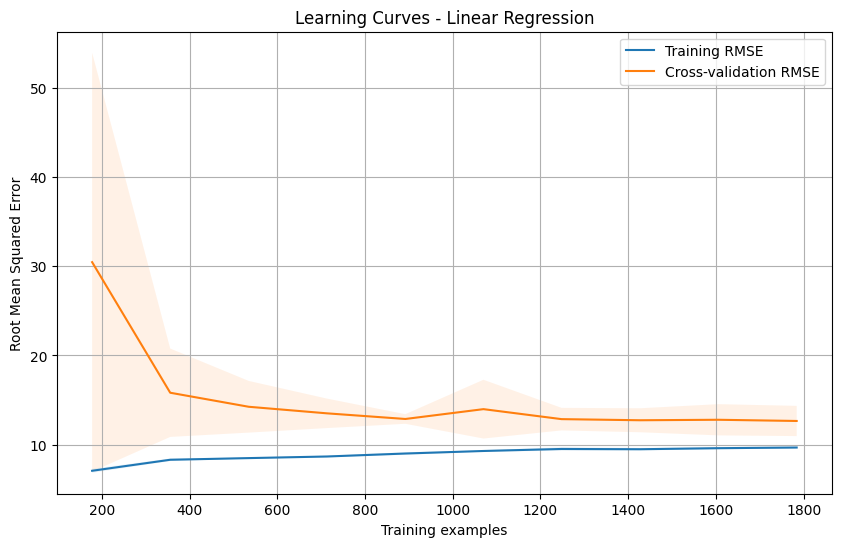

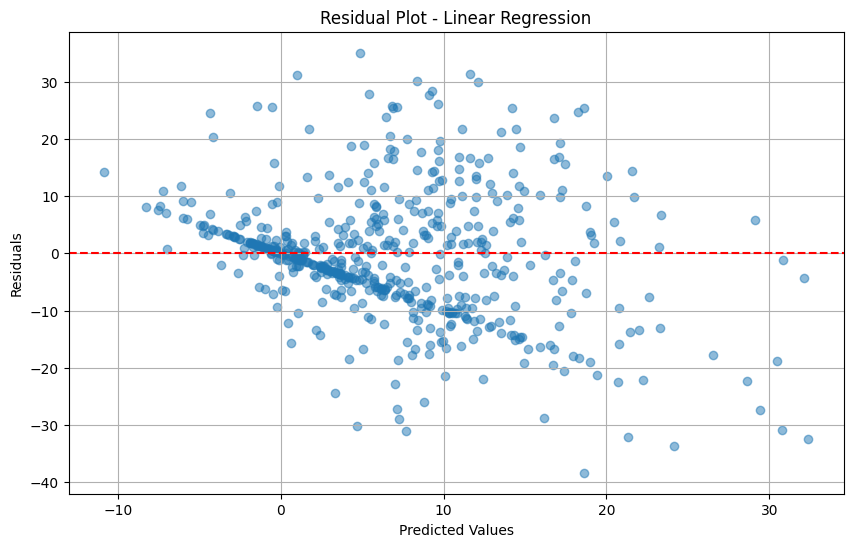

[2/5] Training and evaluating: Ridge Regression... ✓ (GridSearch complete)


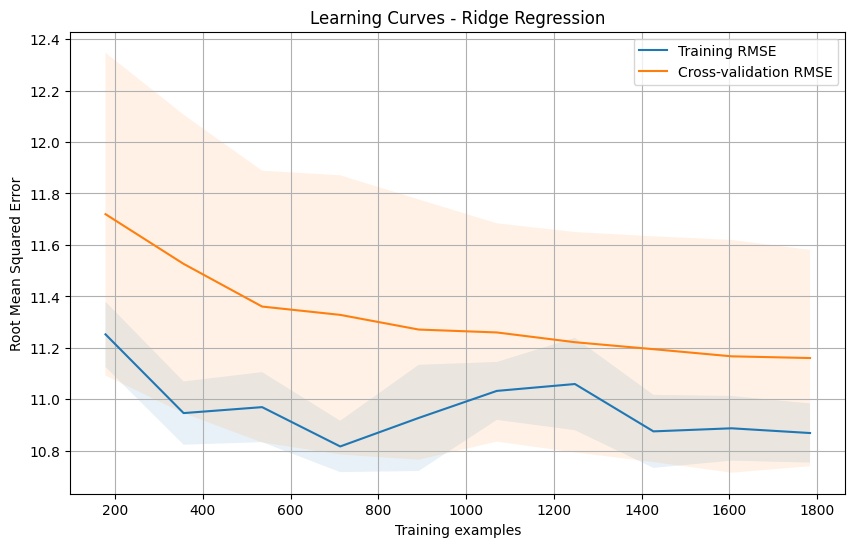

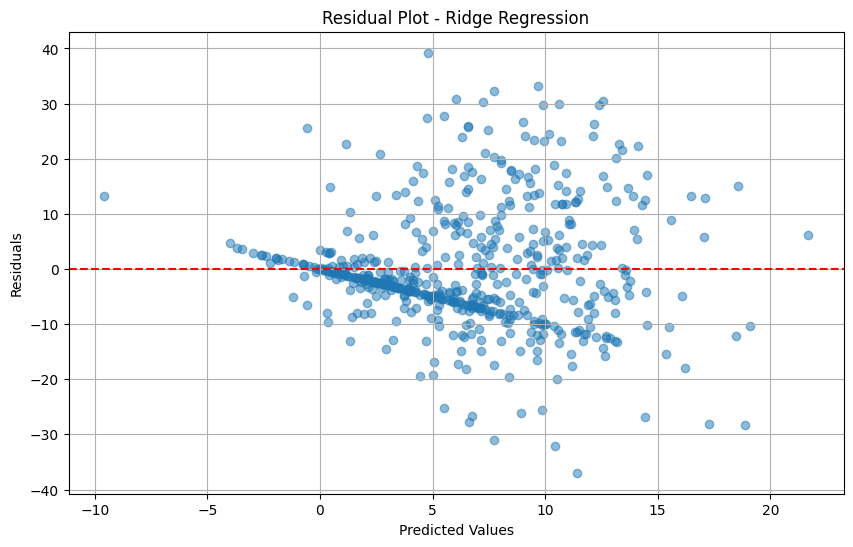

[3/5] Training and evaluating: Lasso Regression... ✓ (GridSearch complete)


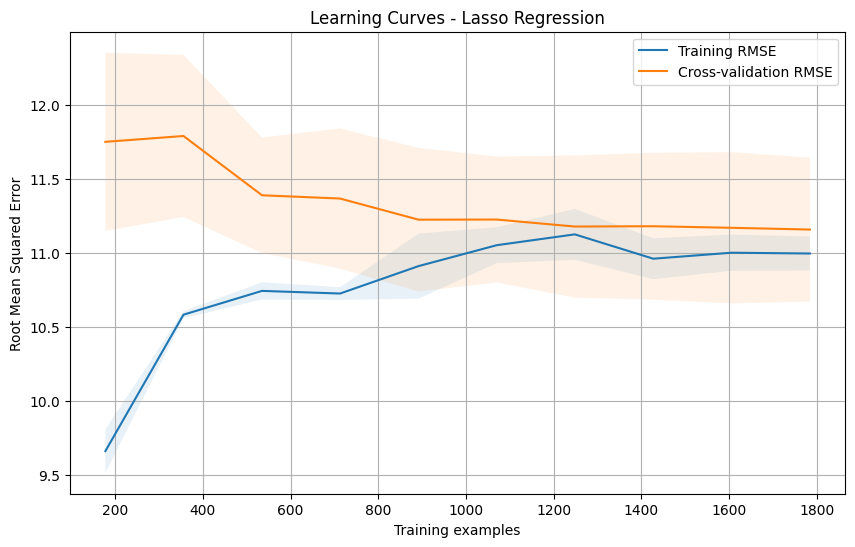

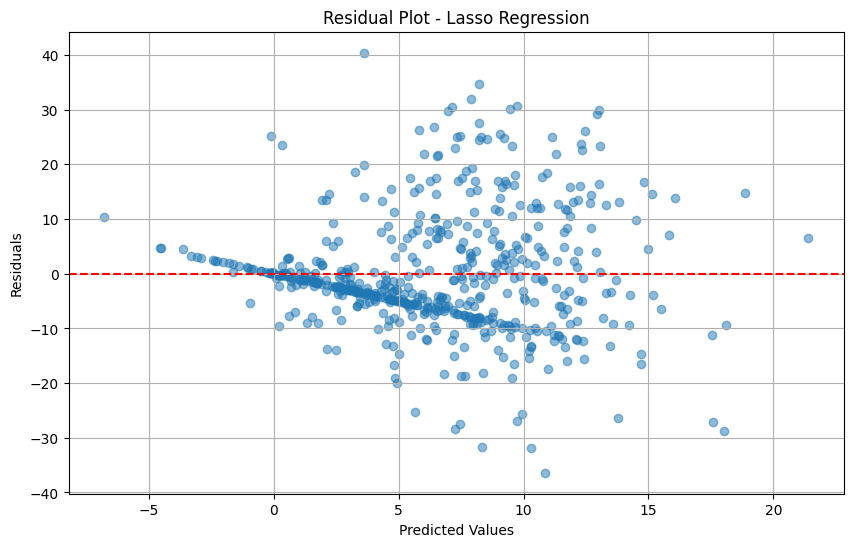

[4/5] Training and evaluating: ElasticNet Regression... ✓ (GridSearch complete)


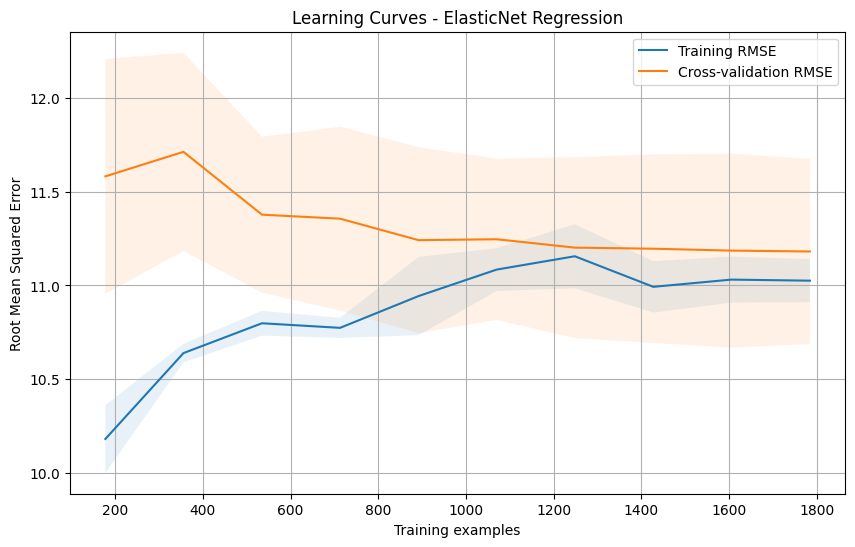

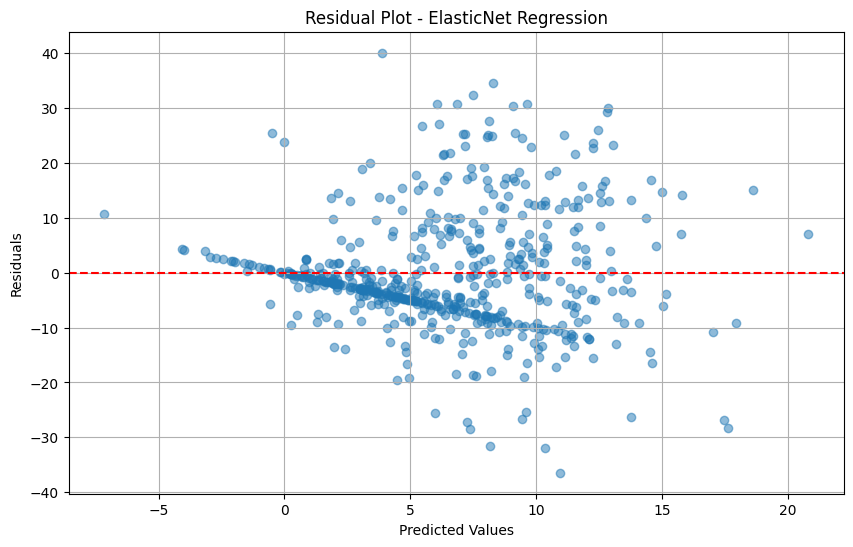

[5/5] Training and evaluating: Support Vector Regressor... ✓ (GridSearch complete)


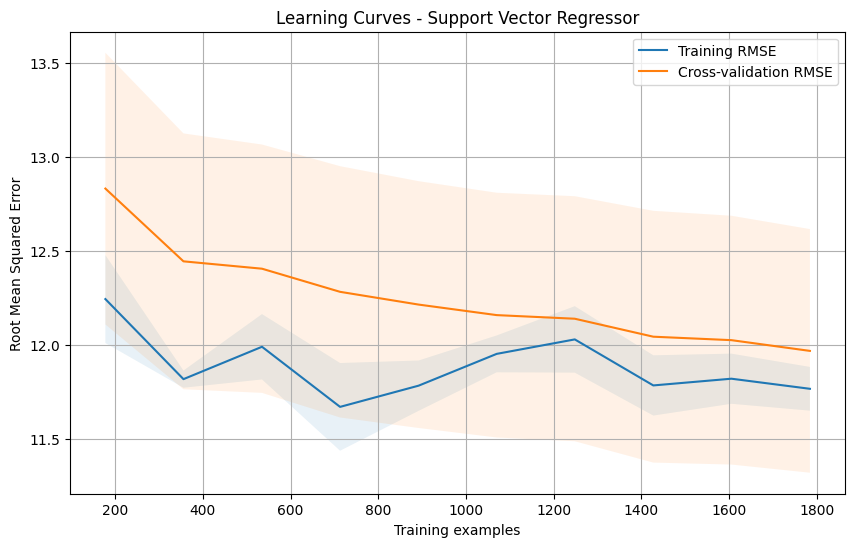

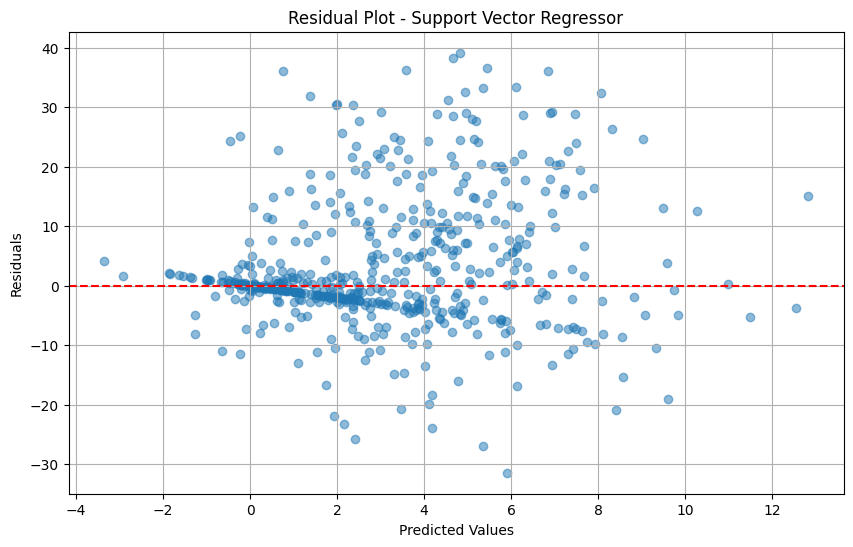


Top 5 Models:


,Model,RMSE,MAE,R² Score,CV RMSE Mean,CV RMSE Std
0,Ridge Regression,10.837207,7.971951,0.147346,11.160623,0.420434
1,Lasso Regression,10.847477,7.937993,0.145729,11.157389,0.485280
2,ElasticNet Regression,10.879878,7.974126,0.140618,11.181020,0.493582
3,Linear Regression,11.100739,8.149064,0.105373,12.658731,1.695634
4,Support Vector Regressor,11.494857,7.639487,0.040720,11.968683,0.647415


In [17]:
main()